# Dependencies

In [123]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling
from modAL.uncertainty import classifier_uncertainty
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense
from keras.activations import relu
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sympy import pretty_print as pp, latex
from scipy.spatial import ConvexHull
from itertools import product

# Data Import

In [89]:
pool3D = pd.read_csv("poolCont3D.csv", header=None)
testDat3D = pd.read_csv("testCont3D.csv", header=None)
startDat3D = pd.read_csv("startDatCont3D.csv", header=None)
gridDat3D = pd.read_csv("gridDat3D.csv", header=None)
rayDat3D = pd.read_csv("rayDat3D.csv", header=None)

In [90]:
startDat3D5= startDat3D[0:5];

In [91]:
startDat3D = startDat3D.to_numpy()
startDat3D5 = startDat3D5.to_numpy()
pool3D = pool3D.to_numpy()
testDat3D = testDat3D.to_numpy()
gridDat3D = gridDat3D.to_numpy()
rayDat3D = rayDat3D.to_numpy()

In [92]:
k1 = 0.01
k2 = 0.1

In [93]:
ystartDat3D = [ptClfy(j) for j in startDat3D]
ystartDat3D5 = [ptClfy(j) for j in startDat3D5]
ypool3D = [ptClfy(j) for j in pool3D]
ytest3D = [ptClfy(j) for j in testDat3D]

# Helper Functions

In [67]:
def acPpt(conc_tuple, kac=0.01):
    if conc_tuple[0]*conc_tuple[2] == 0:
        return 0
    elif conc_tuple[0]*conc_tuple[2] > 0:
        return (conc_tuple[2] >= (kac/conc_tuple[0]))

In [68]:
def bcPpt(conc_tuple, kbc=0.1):
    if conc_tuple[1]*conc_tuple[2] == 0:
        return 0
    elif conc_tuple[1]*conc_tuple[2] > 0:
        return (conc_tuple[2] >= (kbc/conc_tuple[1]))

In [69]:
def ptClfy(conc_tuple):
    if acPpt(conc_tuple) and not(bcPpt(conc_tuple)):
        return 2
    elif not(acPpt(conc_tuple)):
        return 1
    elif acPpt(conc_tuple) and bcPpt(conc_tuple):
        return 3

In [70]:
noise_choice = {
    1: [2, 3],
    2: [1, 3],
    3: [1, 2]
}

In [71]:
def noisy_oracle3D(conc_tuple, noise_pc):
    outcome = np.random.choice([1, -1], p=[(1 - noise_pc), noise_pc])
    if outcome == 1:
        return ptClfy(conc_tuple)
    elif outcome == -1:
        return np.random.choice(noise_choice[ptClfy(conc_tuple)], p=[1/2,1/2])

In [72]:
 svm = SVC(kernel='rbf', probability=True)

In [81]:
def plot_metric(met_history, metric=""):
    fig, ax = plt.subplots(figsize=(8.5, 4), dpi=130)

    ax.plot(met_history)
    ax.scatter(range(len(met_history)), met_history, s=13)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title('Incremental Classification ' + str(metric))
    ax.set_xlabel('Query Iteration')
    ax.set_ylabel('Classification ' + str(metric))

    plt.show()

In [112]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Grid Search

In [303]:
def run_gs_al3D(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        newX, newY = t_pool[index].reshape(1, -1), [noisy_oracle3D(t_pool[index], noise_pc)]
        learner.teach(X=newX, y=newY)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [310]:
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
gs_learner3D, gs_perf_hist3D, gs_mse_hist3D, gs_mcc_hist3D = run_gs_al3D(init_learner3D5, gridDat3D, testDat3D, 0)

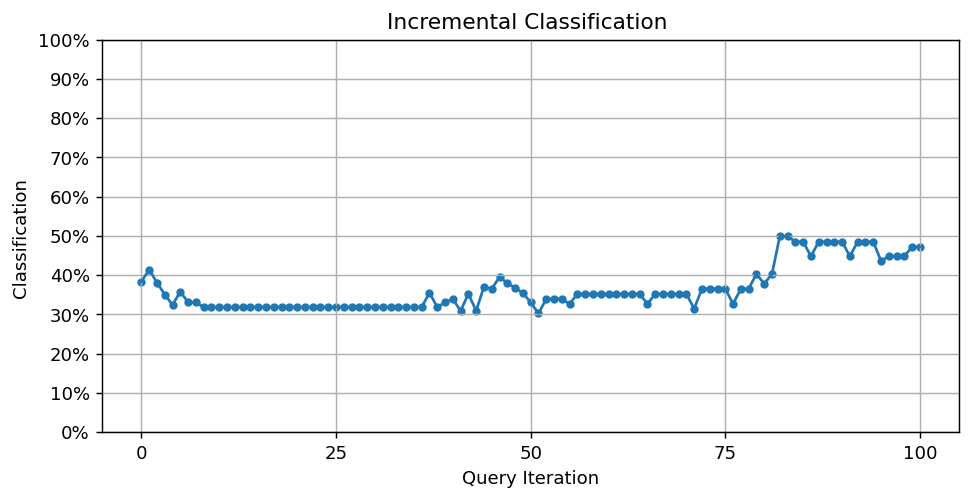

In [311]:
plot_metric(gs_mcc_hist3D)

## Noise

### 10%

In [203]:
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
gs_learner3D10pc, gs_perf_hist3D10pc, gs_mse_hist3D10pc = run_gs_al3D(init_learner3D510pc, gridDat3D, testDat3D, 0.1)

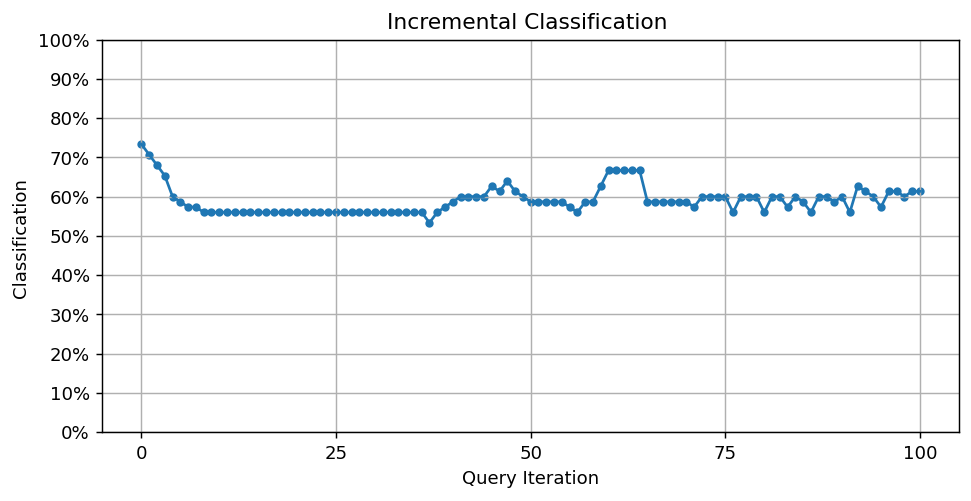

In [204]:
plot_metric(gs_perf_hist3D10pc)

### 20%

In [205]:
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.2) for i in startDat3D5])
gs_learner3D20pc, gs_perf_hist3D20pc, gs_mse_hist3D20pc = run_gs_al3D(init_learner3D520pc, gridDat3D, testDat3D, 0.2)

### 30%

In [207]:
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
gs_learner3D30pc, gs_perf_hist3D30pc, gs_mse_hist3D30pc = run_gs_al3D(init_learner3D530pc, gridDat3D, testDat3D, 0.3)

### 40%

In [208]:
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
gs_learner3D40pc, gs_perf_hist3D40pc, gs_mse_hist3D40pc = run_gs_al3D(init_learner3D540pc, gridDat3D, testDat3D, 0.4)

### 50%

In [209]:
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
gs_learner3D50pc, gs_perf_hist3D50pc, gs_mse_hist3D50pc = run_gs_al3D(init_learner3D550pc, gridDat3D, testDat3D, 0.5)

# Serial Dilution

In [312]:
def run_rd_al3D(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        newX, newY = t_pool[index].reshape(1, -1), [noisy_oracle3D(t_pool[index], noise_pc)]
        learner.teach(X=newX, y=newY)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    del newX, newY
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [313]:
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
rd_learner3D, rd_perf_hist3D, rd_mse_hist3D, rd_mcc_hist3D = run_rd_al3D(init_learner3D5, rayDat3D, testDat3D, 0)

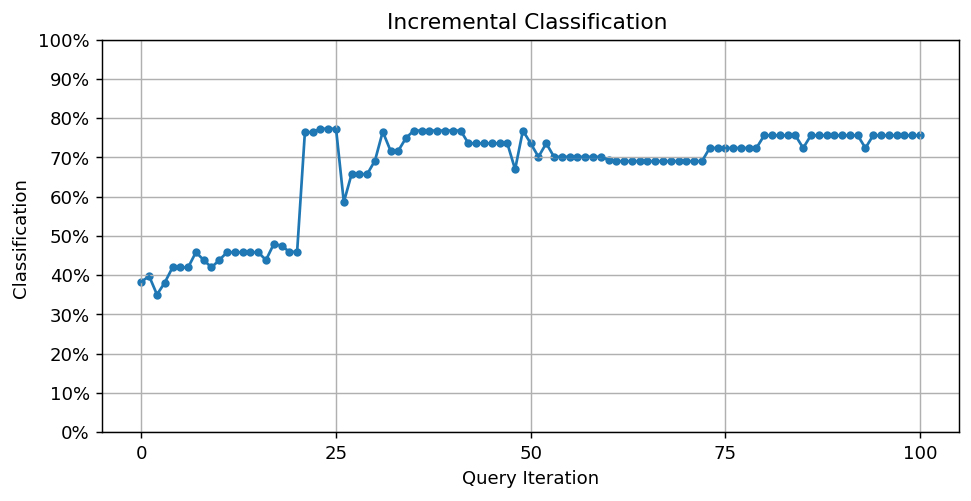

In [314]:
plot_metric(rd_mcc_hist3D)

## Noise

### 10%

In [214]:
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
rd_learner3D10pc, rd_perf_hist3D10pc, rd_mse_hist3D10pc = run_rd_al3D(init_learner3D510pc, rayDat3D, testDat3D, 0.1)

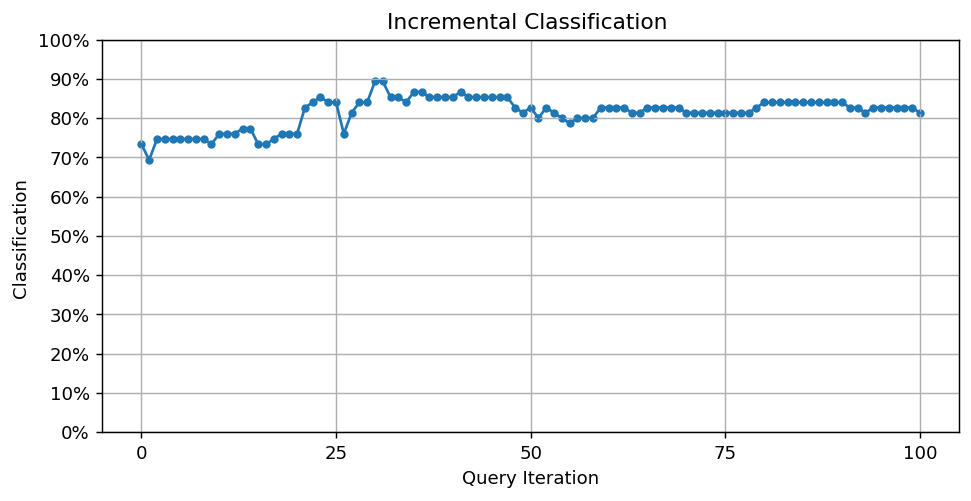

In [215]:
plot_metric(rd_perf_hist3D10pc)

### 20%

In [216]:
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.2) for i in startDat3D5])
rd_learner3D20pc, rd_perf_hist3D20pc, rd_mse_hist3D20pc = run_rd_al3D(init_learner3D520pc, rayDat3D, testDat3D, 0.2)

### 30%

In [217]:
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
rd_learner3D30pc, rd_perf_hist3D30pc, rd_mse_hist3D30pc = run_rd_al3D(init_learner3D530pc, rayDat3D, testDat3D, 0.3)

### 40%

In [218]:
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
rd_learner3D40pc, rd_perf_hist3D40pc, rd_mse_hist3D40pc = run_rd_al3D(init_learner3D540pc, rayDat3D, testDat3D, 0.4)

### 50%

In [219]:
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
rd_learner3D50pc, rd_perf_hist3D50pc, rd_mse_hist3D50pc = run_rd_al3D(init_learner3D550pc, rayDat3D, testDat3D, 0.5)

# Random Add

In [315]:
def run_ra_al3D(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    pool_indices = np.array(len(t_pool))
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for index in range(N_QUERIES):
        query_index = np.random.choice()
        newX, newY = t_pool[query_index].reshape(1, -1), [noisy_oracle3D(t_pool[query_index], noise_pc)]
        learner.teach(X=newX, y=newY)

        t_pool = np.delete(t_pool, query_index, axis=0)
        pool_indices = np.delete(pool_indices, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    del newX, newY
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [316]:
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
ra_learner3D, ra_perf_hist3D, ra_mse_hist3D, ra_mcc_hist3D = run_rd_al3D(init_learner3D5, pool3D, testDat3D, 0)

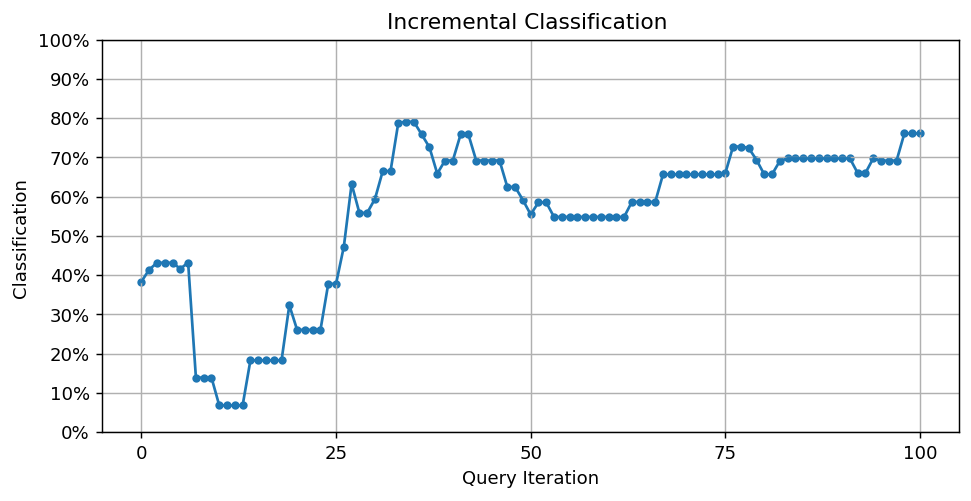

In [317]:
plot_metric(ra_mcc_hist3D)

## Noise

### 10%

In [229]:
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
ra_learner3D10pc, ra_perf_hist3D10pc, ra_mse_hist3D10pc = run_rd_al3D(init_learner3D510pc, pool3D, testDat3D, 0.1)

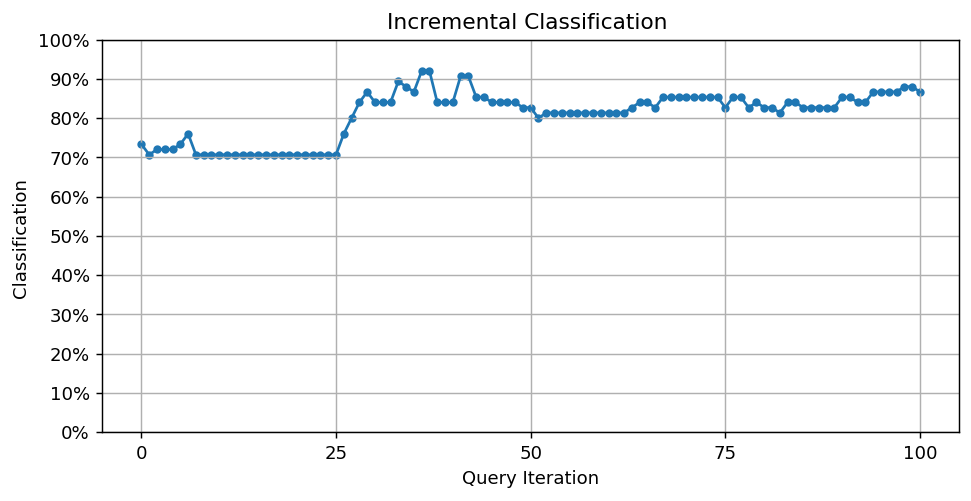

In [230]:
plot_metric(ra_perf_hist3D10pc)

### 20%

In [231]:
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
ra_learner3D20pc, ra_perf_hist3D20pc, ra_mse_hist3D20pc = run_rd_al3D(init_learner3D520pc, pool3D, testDat3D, 0.2)

### 30%

In [232]:
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
ra_learner3D30pc, ra_perf_hist3D30pc, ra_mse_hist3D30pc = run_rd_al3D(init_learner3D530pc, pool3D, testDat3D, 0.3)

### 40%

In [233]:
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
ra_learner3D40pc, ra_perf_hist3D40pc, ra_mse_hist3D40pc = run_rd_al3D(init_learner3D540pc, pool3D, testDat3D, 0.4)

### 50%

In [234]:
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
ra_learner3D50pc, ra_perf_hist3D50pc, ra_mse_hist3D50pc = run_rd_al3D(init_learner3D550pc, pool3D, testDat3D, 0.5)

# Uncertainty

In [318]:
def run_u_al3D(starting_learner, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        query_index, query_instance = learner.query(t_pool)
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle3D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY, query_index, query_instance

## Noiseless

In [319]:
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
u_learner3D, u_perf_hist3D, u_mse_hist3D, u_mcc_hist3D = run_u_al3D(init_learner3D5, pool3D, testDat3D, 0)

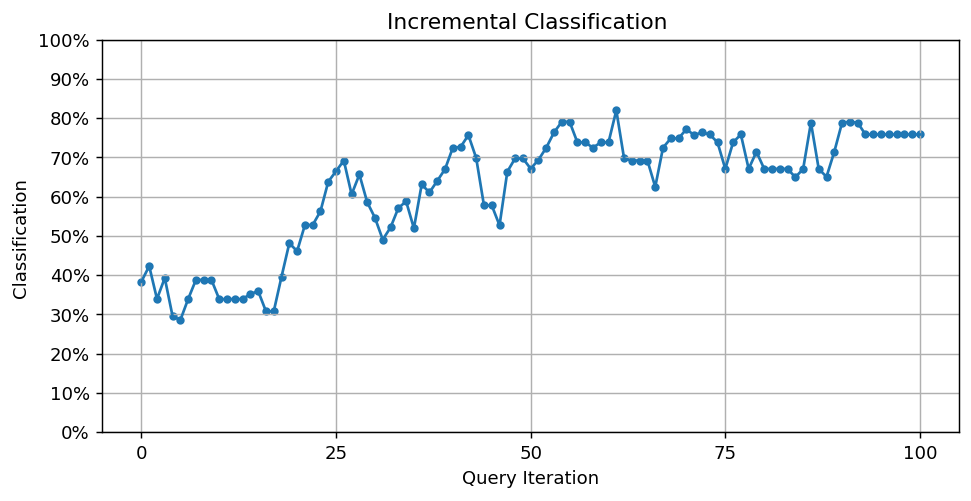

In [320]:
plot_metric(u_mcc_hist3D)

## Noise

### 10%

In [222]:
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
u_learner3D10pc, u_perf_hist3D10pc, u_mse_hist3D10pc = run_u_al3D(init_learner3D510pc, pool3D, testDat3D, 0.1)

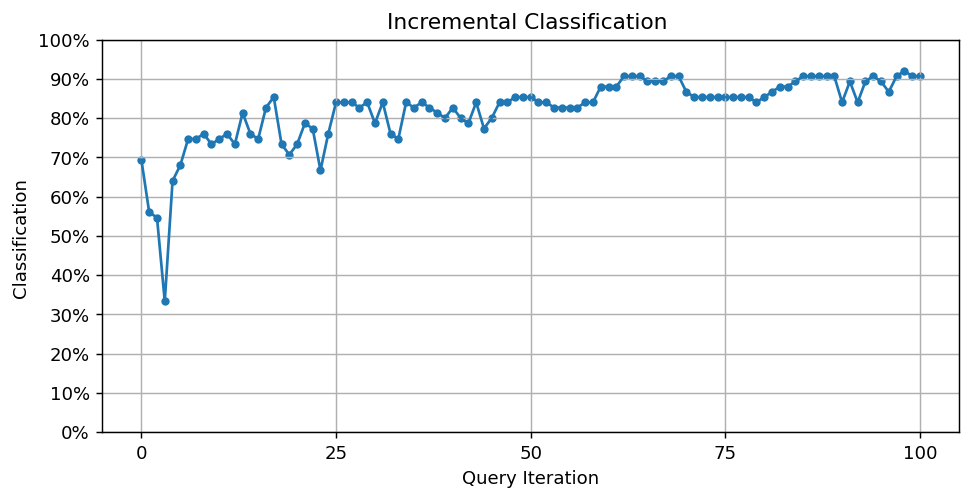

In [223]:
plot_metric(u_perf_hist3D10pc)

### 20%

In [224]:
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.2) for i in startDat3D5])
u_learner3D20pc, u_perf_hist3D20pc, u_mse_hist3D20pc = run_u_al3D(init_learner3D520pc, pool3D, testDat3D, 0.2)

### 30%

In [226]:
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
u_learner3D30pc, u_perf_hist3D30pc, u_mse_hist3D30pc = run_u_al3D(init_learner3D530pc, pool3D, testDat3D, 0.3)

### 40%

In [227]:
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
u_learner3D40pc, u_perf_hist3D40pc, u_mse_hist3D40pc = run_u_al3D(init_learner3D540pc, pool3D, testDat3D, 0.4)

### 50%

In [228]:
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
u_learner3D50pc, u_perf_hist3D50pc, u_mse_hist3D50pc = run_u_al3D(init_learner3D550pc, pool3D, testDat3D, 0.5)

# QBC

In [106]:
def make_committee3D(starting_dat, noise_pc):
    l1 = ActiveLearner(svm, X_training=starting_dat, y_training=[noisy_oracle3D(i, noise_pc) for i in starting_dat])
    l2 = ActiveLearner(KNeighborsClassifier(), X_training=starting_dat, y_training=[noisy_oracle3D(i, noise_pc) for i in starting_dat])
    l3 = ActiveLearner(GaussianNB(), X_training=starting_dat, y_training=[noisy_oracle3D(i, noise_pc) for i in starting_dat])
    l4 = ActiveLearner(RandomForestClassifier(), X_training=starting_dat, y_training=[noisy_oracle3D(i, noise_pc) for i in starting_dat])
    l5 = ActiveLearner(DecisionTreeClassifier(), X_training=starting_dat, y_training=[noisy_oracle3D(i, noise_pc) for i in starting_dat])
    learner_list = [l1, l2, l3, l4, l5]
    return Committee(learner_list, query_strategy=vote_entropy_sampling)
    del l1, l2, l3, l4, l5, learner_list

In [323]:
def run_qbc_al3D(starting_committee, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    committee = starting_committee
    perf_hist = [committee.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, committee.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, committee.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        query_index, query_instance = committee.query(t_pool)
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle3D(t_pool[int(query_index)], noise_pc)]
        committee.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = committee.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, committee.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, committee.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    return committee, perf_hist, mse_hist, mcc_hist
    del committee, starting_committee, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [324]:
init_committee3D = make_committee3D(startDat3D5, 0)
qbc_learner3D, qbc_perf_hist3D, qbc_mse_hist3D, qbc_mcc_hist3D = run_qbc_al3D(init_committee3D, pool3D, testDat3D, 0)

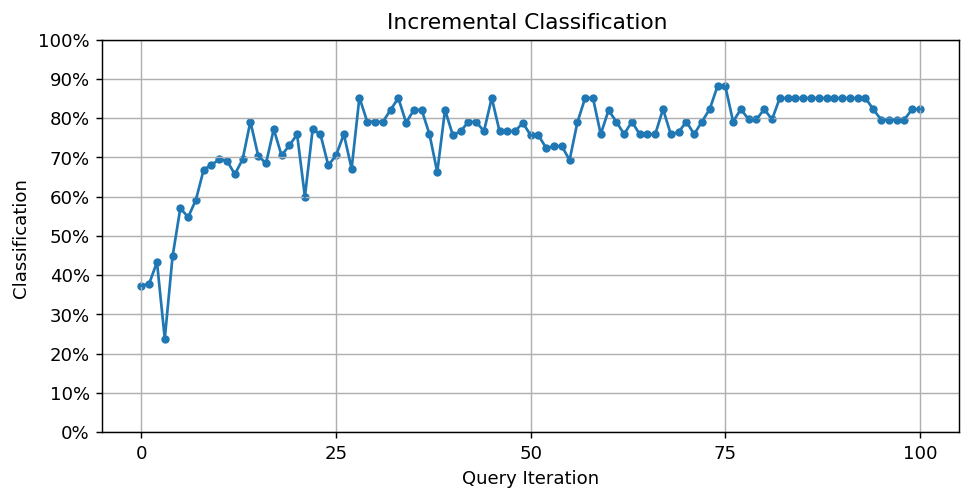

In [325]:
plot_metric(qbc_mcc_hist3D)

## Noise

### 10%

In [238]:
init_committee3D10pc = make_committee3D(startDat3D5, 0.1)
qbc_learner3D10pc, qbc_perf_hist3D10pc, qbc_mse_hist3D10pc = run_qbc_al3D(init_committee3D10pc, pool3D, testDat3D, 0.1)

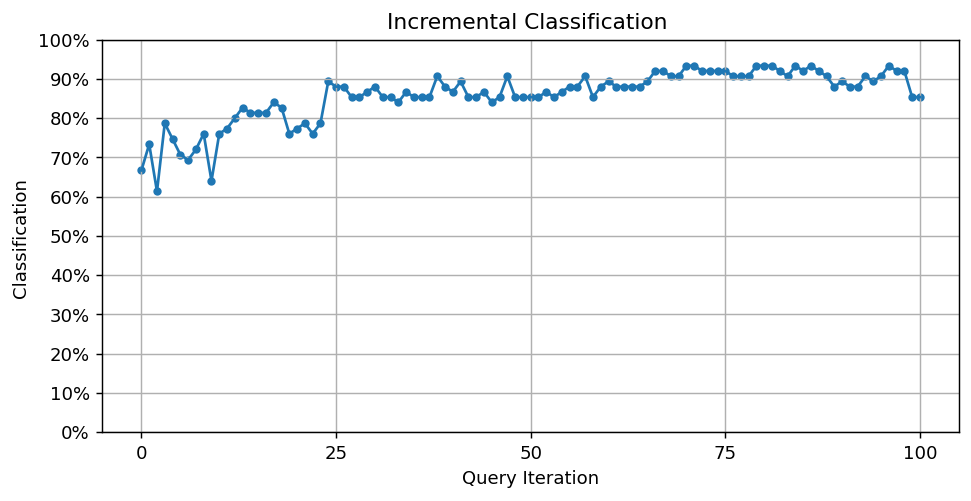

In [239]:
plot_metric(qbc_perf_hist3D10pc)

### 20%

In [240]:
init_committee3D20pc = make_committee3D(startDat3D5, 0.2)
qbc_learner3D20pc, qbc_perf_hist3D20pc, qbc_mse_hist3D20pc = run_qbc_al3D(init_committee3D20pc, pool3D, testDat3D, 0.2)

### 30%

In [241]:
init_committee3D30pc = make_committee3D(startDat3D5, 0.3)
qbc_learner3D30pc, qbc_perf_hist3D30pc, qbc_mse_hist3D30pc = run_qbc_al3D(init_committee3D30pc, pool3D, testDat3D, 0.3)

### 40%

In [242]:
init_committee3D40pc = make_committee3D(startDat3D5, 0.4)
qbc_learner3D40pc, qbc_perf_hist3D40pc, qbc_mse_hist3D40pc = run_qbc_al3D(init_committee3D40pc, pool3D, testDat3D, 0.4)

### 50%

In [243]:
init_committee3D50pc = make_committee3D(startDat3D5, 0.5)
qbc_learner3D50pc, qbc_perf_hist3D50pc, qbc_mse_hist3D50pc = run_qbc_al3D(init_committee3D50pc, pool3D, testDat3D, 0.5)

# LTS

In [326]:
def run_lts_al3D(starting_learner, starting_regressor, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        query_index = np.random.choice(range(len(t_pool)), p=softmax(uncertainties))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle3D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [327]:
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
lts_reg_learner3D = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D5, startDat3D5))
lts_learner3D, lts_perf_hist3D, lts_mse_hist3D, lts_mcc_hist3D = run_lts_al3D(init_learner3D5, lts_reg_learner3D, pool3D, testDat3D, 0)

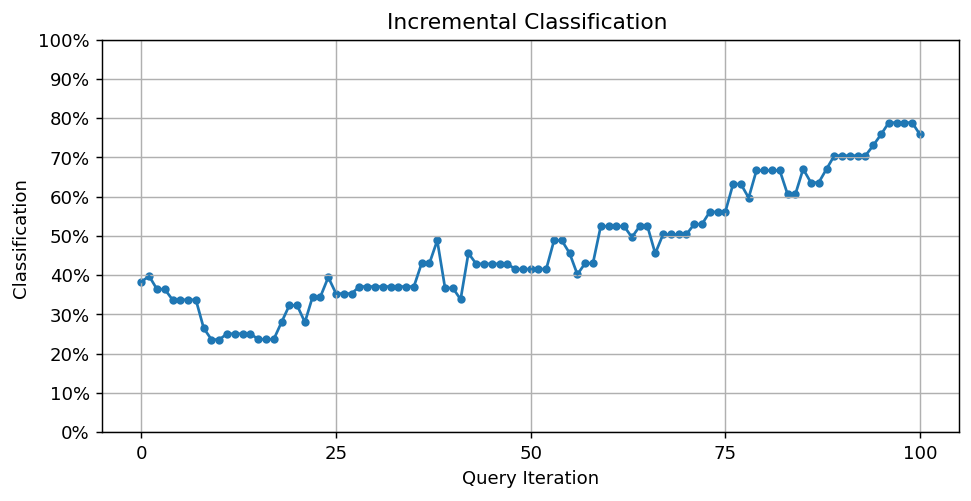

In [328]:
plot_metric(lts_mcc_hist3D)

## Noise

### 10%

In [264]:
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
lts_reg_learner3D10pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D510pc, startDat3D5))
lts_learner3D10pc, lts_perf_hist3D10pc, lts_mse_hist3D10pc = run_lts_al3D(init_learner3D510pc, lts_reg_learner3D10pc, pool3D, testDat3D, 0.1)

### 20%

In [265]:
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.2) for i in startDat3D5])
lts_reg_learner3D20pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D520pc, startDat3D5))
lts_learner3D20pc, lts_perf_hist3D20pc, lts_mse_hist3D20pc = run_lts_al3D(init_learner3D520pc, lts_reg_learner3D20pc, pool3D, testDat3D, 0.2)

### 30%

In [266]:
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
lts_reg_learner3D30pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D530pc, startDat3D5))
lts_learner3D30pc, lts_perf_hist3D30pc, lts_mse_hist3D30pc = run_lts_al3D(init_learner3D530pc, lts_reg_learner3D30pc, pool3D, testDat3D, 0.3)

### 40%

In [267]:
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
lts_reg_learner3D40pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D540pc, startDat3D5))
lts_learner3D40pc, lts_perf_hist3D40pc, lts_mse_hist3D40pc = run_lts_al3D(init_learner3D540pc, lts_reg_learner3D40pc, pool3D, testDat3D, 0.4)

### 50%

In [268]:
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
lts_reg_learner3D50pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D550pc, startDat3D5))
lts_learner3D50pc, lts_perf_hist3D50pc, lts_mse_hist3D50pc = run_lts_al3D(init_learner3D550pc, lts_reg_learner3D50pc, pool3D, testDat3D, 0.5)

# LTSR

In [329]:
def run_ltsr_al3D(starting_learner, starting_regressor, clusterer, pool_data, test_data, noise_pc, alpha, num_queries=100):
    t_pool = pool_data[:]
    clust1 = []
    clust2 = []
    clust3 = []
    for i in t_pool:
        if kmeans.predict(i.reshape(1, -1))[0] == 0:
            clust1.append(i)
        elif kmeans.predict(i.reshape(1, -1))[0] == 1:
            clust2.append(i)
        elif kmeans.predict(i.reshape(1, -1))[0] == 2:
            clust3.append(i)
    clusts = [clust1, clust2, clust3]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        regs = [sum(np.linalg.norm(clusts[clusterer.predict(i.reshape(1, -1))[0]], axis=1)) for i in t_pool]
        zipped = zip(uncertainties, regs)
        weights = [x + alpha*y for (x, y) in zipped]

        query_index = np.random.choice(range(len(t_pool)), p=softmax(weights))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle3D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [330]:
kmeans = KMeans(n_clusters=3).fit(pool3D)
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
ltsr_reg_learner3D = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D5, startDat3D5))
ltsr_learner3D, ltsr_perf_hist3D, ltsr_mse_hist3D, ltsr_mcc_hist3D = run_ltsr_al3D(init_learner3D5, ltsr_reg_learner3D, kmeans, pool3D, testDat3D, 0, 1.5)

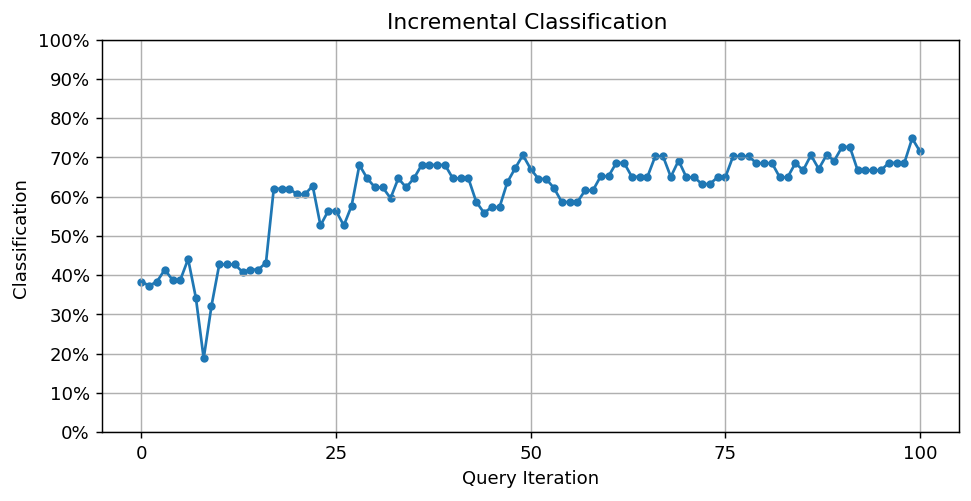

In [331]:
plot_metric(ltsr_mcc_hist3D)

## Noise

### 10%

In [269]:
kmeans10pc = KMeans(n_clusters=3).fit(pool3D)
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
ltsr_reg_learner3D10pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D510pc, startDat3D5))
ltsr_learner3D10pc, ltsr_perf_hist3D10pc, ltsr_mse_hist3D10pc = run_ltsr_al3D(init_learner3D510pc, ltsr_reg_learner3D10pc, kmeans10pc, pool3D, testDat3D, 0.1, 1.5)

### 20%

In [270]:
kmeans20pc = KMeans(n_clusters=3).fit(pool3D)
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.2) for i in startDat3D5])
ltsr_reg_learner3D20pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D520pc, startDat3D5))
ltsr_learner3D20pc, ltsr_perf_hist3D20pc, ltsr_mse_hist3D20pc = run_ltsr_al3D(init_learner3D520pc, ltsr_reg_learner3D20pc, kmeans20pc, pool3D, testDat3D, 0.2, 1.5)

### 30%

In [271]:
kmeans30pc = KMeans(n_clusters=3).fit(pool3D)
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
ltsr_reg_learner3D30pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D530pc, startDat3D5))
ltsr_learner3D30pc, ltsr_perf_hist3D30pc, ltsr_mse_hist3D30pc = run_ltsr_al3D(init_learner3D530pc, ltsr_reg_learner3D30pc, kmeans30pc, pool3D, testDat3D, 0.3, 1.5)

### 40%

In [272]:
kmeans40pc = KMeans(n_clusters=3).fit(pool3D)
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
ltsr_reg_learner3D40pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D540pc, startDat3D5))
ltsr_learner3D40pc, ltsr_perf_hist3D40pc, ltsr_mse_hist3D40pc = run_ltsr_al3D(init_learner3D540pc, ltsr_reg_learner3D40pc, kmeans40pc, pool3D, testDat3D, 0.4, 1.5)

### 50%

In [273]:
kmeans50pc = KMeans(n_clusters=3).fit(pool3D)
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
ltsr_reg_learner3D50pc = ActiveLearner(estimator=LinearRegression(), X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D550pc, startDat3D5))
ltsr_learner3D50pc, ltsr_perf_hist3D50pc, ltsr_mse_hist3D50pc = run_ltsr_al3D(init_learner3D550pc, ltsr_reg_learner3D50pc, kmeans50pc, pool3D, testDat3D, 0.5, 1.5)

# LTSNN

In [115]:
def nn_regressor():
    nn_model = Sequential()
    nn_model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    nn_model.add(Dense(8, activation='linear'))
    nn_model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    nn_model.add(BatchNormalization())
    nn_model.add(Dense(1, activation='relu'))

    nn_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']);
    return nn_model
    del nn_model

In [332]:
def run_ltsnn_al3D(starting_learner, starting_regressor, pool_data, test_data, noise_pc, num_queries=100):
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    learner = starting_learner
    regressor = starting_regressor
    perf_hist = [learner.score(test_data, t_ytest)]
    mse_hist = [sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))]
    mcc_hist = [sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))]
    N_QUERIES = num_queries
    for i in range(N_QUERIES):
        uncertainties = regressor.predict(t_pool)
        query_index = np.random.choice(range(len(t_pool)), p=softmax(uncertainties))
        query_instance = t_pool[query_index]
        newX, newY = [t_pool[int(query_index)]], [noisy_oracle3D(t_pool[int(query_index)], noise_pc)]
        learner.teach(X=newX, y=newY)
        regressor.teach(X=newX, y=newY)

        t_pool, t_ypool = np.delete(t_pool, query_index, axis=0), np.delete(t_ypool, query_index, axis=0)

        model_accuracy = learner.score(test_data, t_ytest)
        model_mse = sklearn.metrics.mean_squared_error(t_ytest, learner.predict(test_data))
        model_mcc = sklearn.metrics.matthews_corrcoef(t_ytest, learner.predict(test_data))

        perf_hist.append(model_accuracy)
        mse_hist.append(model_mse)
        mcc_hist.append(model_mcc)
    t_pool = pool_data[:]
    t_ypool = [ptClfy(i) for i in t_pool]
    t_ytest = [ptClfy(i) for i in test_data]
    return learner, perf_hist, mse_hist, mcc_hist
    del learner, starting_learner, pool_data, test_data, noise_pc, num_queries, perf_hist, model_accuracy, perf_hist, X, y, index, newX, newY

## Noiseless

In [333]:
init_learner3D5 = ActiveLearner(svm, X_training=startDat3D5, y_training=ystartDat3D5)
nn_init3D = KerasRegressor(nn_regressor)
nn_reg_init3D = ActiveLearner(
    estimator=nn_init3D,
    X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D5, startDat3D5)
)
ltsnn_learner3D, ltsnn_perf_hist3D, ltsnn_mse_hist3D, ltsnn_mcc_hist3D = run_lts_al3D(init_learner3D5, nn_reg_init3D, pool3D, testDat3D, 0)

4/4 [==============================] - 1s 2ms/step - loss: 3.6617 - mse: 3.6617 - mae: 1.7808


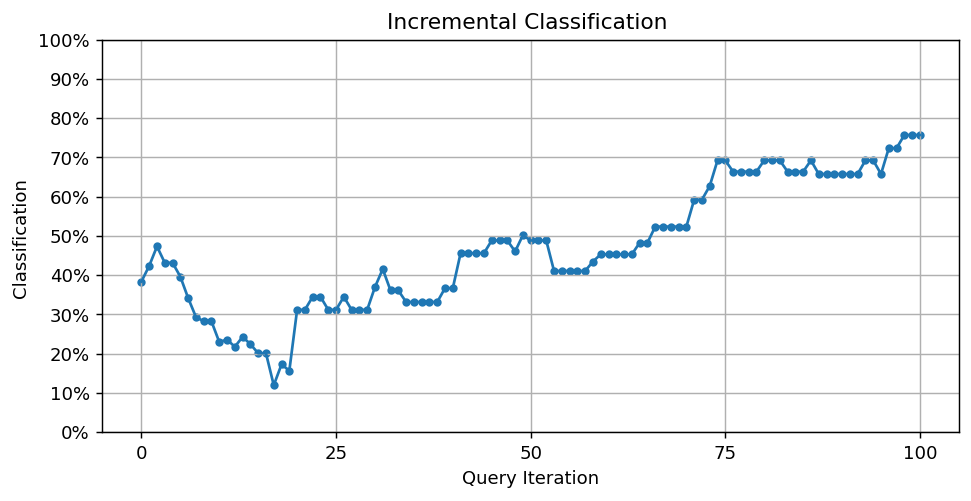

In [334]:
plot_metric(ltsnn_mcc_hist3D)

## Noise

### 10%

In [274]:
init_learner3D510pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.1) for i in startDat3D5])
nn_init3D10pc = KerasRegressor(nn_regressor)
nn_reg_init3D10pc = ActiveLearner(
    estimator=nn_init3D10pc,
    X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D510pc, startDat3D5)
)
ltsnn_learner3D10pc, ltsnn_perf_hist3D10pc, ltsnn_mse_hist3D10pc = run_lts_al3D(init_learner3D510pc, nn_reg_init3D10pc, pool3D, testDat3D, 0.1)

4/4 [==============================] - 1s 2ms/step - loss: 4.2544 - mse: 4.2544 - mae: 1.9466


### 20%

In [275]:
init_learner3D520pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.2) for i in startDat3D5])
nn_init3D20pc = KerasRegressor(nn_regressor)
nn_reg_init3D20pc = ActiveLearner(
    estimator=nn_init3D20pc,
    X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D520pc, startDat3D5)
)
ltsnn_learner3D20pc, ltsnn_perf_hist3D20pc, ltsnn_mse_hist3D20pc = run_lts_al3D(init_learner3D520pc, nn_reg_init3D20pc, pool3D, testDat3D, 0.2)

4/4 [==============================] - 1s 2ms/step - loss: 4.2351 - mse: 4.2351 - mae: 1.9228


### 30%

In [276]:
init_learner3D530pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.3) for i in startDat3D5])
nn_init3D30pc = KerasRegressor(nn_regressor)
nn_reg_init3D30pc = ActiveLearner(
    estimator=nn_init3D30pc,
    X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D530pc, startDat3D5)
)
ltsnn_learner3D30pc, ltsnn_perf_hist3D30pc, ltsnn_mse_hist3D30pc = run_lts_al3D(init_learner3D530pc, nn_reg_init3D30pc, pool3D, testDat3D, 0.3)

4/4 [==============================] - 1s 2ms/step - loss: 3.8227 - mse: 3.8227 - mae: 1.7971


### 40%

In [277]:
init_learner3D540pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.4) for i in startDat3D5])
nn_init3D40pc = KerasRegressor(nn_regressor)
nn_reg_init3D40pc = ActiveLearner(
    estimator=nn_init3D40pc,
    X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D540pc, startDat3D5)
)
ltsnn_learner3D40pc, ltsnn_perf_hist3D40pc, ltsnn_mse_hist3D40pc = run_lts_al3D(init_learner3D540pc, nn_reg_init3D40pc, pool3D, testDat3D, 0.4)

4/4 [==============================] - 1s 2ms/step - loss: 4.4257 - mse: 4.4257 - mae: 1.9402


### 50%

In [278]:
init_learner3D550pc = ActiveLearner(svm, X_training=startDat3D5, y_training=[noisy_oracle3D(i, 0.5) for i in startDat3D5])
nn_init3D50pc = KerasRegressor(nn_regressor)
nn_reg_init3D50pc = ActiveLearner(
    estimator=nn_init3D50pc,
    X_training=startDat3D5, y_training=classifier_uncertainty(init_learner3D550pc, startDat3D5)
)
ltsnn_learner3D50pc, ltsnn_perf_hist3D50pc, ltsnn_mse_hist3D50pc = run_lts_al3D(init_learner3D550pc, nn_reg_init3D50pc, pool3D, testDat3D, 0.5)

4/4 [==============================] - 1s 2ms/step - loss: 4.3647 - mse: 4.3647 - mae: 1.9358


# Analysis

## Noiseless

In [305]:
gsBar = gs_mcc_hist3D[0:125:25]
rdBar = rd_mcc_hist3D[0:125:25]
raBar = ra_mcc_hist3D[0:125:25]
uBar = u_mcc_hist3D[0:125:25]
qbcBar = qbc_mcc_hist3D[0:125:25]
ltsBar = lts_mcc_hist3D[0:125:25]
ltsrBar = ltsr_mcc_hist3D[0:125:25]
ltsnnBar = ltsnn_mcc_hist3D[0:125:25]

In [306]:
barDat3D = [gsBar, rdBar, raBar, uBar, qbcBar, ltsBar, ltsrBar, ltsnnBar]

In [284]:
np.savetxt('barDatMCC3D.txt', np.array(barDat3D))

## Noise

In [301]:
k = 100
accs100Noise3D = [[gs_perf_hist3D10pc[k], rd_perf_hist3D10pc[k], ra_perf_hist3D10pc[k], u_perf_hist3D10pc[k], qbc_perf_hist3D10pc[k], lts_perf_hist3D10pc[k], ltsr_perf_hist3D10pc[k], ltsnn_perf_hist3D10pc[k]], 
[gs_perf_hist3D20pc[k], rd_perf_hist3D20pc[k], ra_perf_hist3D20pc[k], u_perf_hist3D20pc[k], qbc_perf_hist3D20pc[k], lts_perf_hist3D20pc[k], ltsr_perf_hist3D20pc[k], ltsnn_perf_hist3D20pc[k]], 
[gs_perf_hist3D30pc[k], rd_perf_hist3D30pc[k], ra_perf_hist3D30pc[k], u_perf_hist3D30pc[k], qbc_perf_hist3D30pc[k], lts_perf_hist3D30pc[k], ltsr_perf_hist3D30pc[k], ltsnn_perf_hist3D30pc[k]], 
[gs_perf_hist3D40pc[k], rd_perf_hist3D40pc[k], ra_perf_hist3D40pc[k], u_perf_hist3D40pc[k], qbc_perf_hist3D40pc[k], lts_perf_hist3D40pc[k], ltsr_perf_hist3D40pc[k], ltsnn_perf_hist3D40pc[k]], 
[gs_perf_hist3D50pc[k], rd_perf_hist3D50pc[k], ra_perf_hist3D50pc[k], u_perf_hist3D50pc[k], qbc_perf_hist3D50pc[k], lts_perf_hist3D50pc[k], ltsr_perf_hist3D50pc[k], ltsnn_perf_hist3D50pc[k]]]

In [302]:
np.savetxt('accs100Noise3D.txt', np.array(accs100Noise3D))